In [5]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import statsmodels.api as sm
import sklearn
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")
sns.set()

In [25]:
df_gspc = yf.download('^GSPC', start="1994-01-07", end="2019-09-01", interval="1d")
df_gspc = df_gspc[["Close"]]
df_ftse = yf.download("^FTSE", start="1994-01-07", end="2019-09-01", interval="1d")
df_ftse = df_ftse[["Close"]]
df_n225 = yf.download("^N225", start="1994-01-07", end="2019-09-01", interval="1d")
df_n225 = df_n225[["Close"]]
df_gdaxi = yf.download("^GDAXI", start="1994-01-07", end="2019-09-01", interval="1d")
df_gdaxi = df_gdaxi[["Close"]]

#merge all dataframes
df = df_gspc.join(df_ftse, how="outer", lsuffix="_gspc", rsuffix="_ftse")
df = df.join(df_n225, how="outer", rsuffix="_n225")
df = df.join(df_gdaxi, how="outer", rsuffix="_gdaxi")
df.columns = ["gspc", "ftse", "n225", "gdaxi"]

# columns names spx, dax, ftse, nikkei
df = df.rename(columns={"gspc": "spx", "gdaxi": "dax", "ftse": "ftse", "n225": "nikkei"})
df = df.asfreq("b")  # Business day frequency
df = df.fillna(method="ffill")  # Forward fill to handle missing values
df = df.dropna()


#returns
df['ret_spx'] = df['spx'].pct_change(1)*100
df['ret_dax'] = df['dax'].pct_change(1)*100
df['ret_ftse'] = df['ftse'].pct_change(1)*100
df['ret_nikkei'] = df['nikkei'].pct_change(1)*100

#normalizing the data
df['norm_ret_spx'] = df.ret_spx.div(df.ret_spx[1])*100
df['norm_ret_dax'] = df.ret_dax.div(df.ret_dax[1])*100
df['norm_ret_ftse'] = df.ret_ftse.div(df.ret_ftse[1])*100
df['norm_ret_nikkei'] = df.ret_nikkei.div(df.ret_nikkei[1])*100

df_full = df.copy()
df_full = df_full[1:]
# splitting the data into training and testing sets
train_size = int(len(df) * 0.8)
df, df_test = df.iloc[:train_size], df.iloc[train_size:]
df = df[1:]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Fitting simple AR Model

### Fitting the model

In [26]:
# Fitting simple AR Model
model_ar = ARIMA(df.ftse, order=(1, 0, 0))
result_ar = model_ar.fit()

### Simple forecasting

In [27]:
df.tail()

,spx,ftse,nikkei,dax,ret_spx,ret_dax,ret_ftse,ret_nikkei,norm_ret_spx,norm_ret_dax,norm_ret_ftse,norm_ret_nikkei
Date,,,,,,,,,,,,
2014-07-08,1963.709961,6738.500000,15314.410156,9772.669922,-0.704880,-1.346653,-1.245695,-0.422839,-61.680354,-59866.246313,794.952349,-23.991315
2014-07-09,1972.829956,6718.000000,15302.650391,9808.200195,0.464427,0.363568,-0.304222,-0.076789,40.639543,16162.615912,194.142222,-4.356898
2014-07-10,1964.680054,6672.399902,15216.469727,9659.129883,-0.413107,-1.519854,-0.678775,-0.563175,-36.148835,-67565.994483,433.166778,-31.953776
2014-07-11,1967.569946,6690.200195,15164.040039,9666.339844,0.147092,0.074644,0.266775,-0.344559,12.871270,3318.342727,-170.245033,-19.549802
2014-07-14,1977.099976,6746.100098,15296.820312,9783.009766,0.484355,1.206971,0.835549,0.875626,42.383382,53656.603796,-533.213704,49.681837


In [43]:
start_date = df.index[-1] + pd.Timedelta(days=1)
end_date = "2019-09-01"

In [44]:
end_date

'2019-09-01'

In [45]:
df_pred = result_ar.predict(start=start_date, end=end_date)

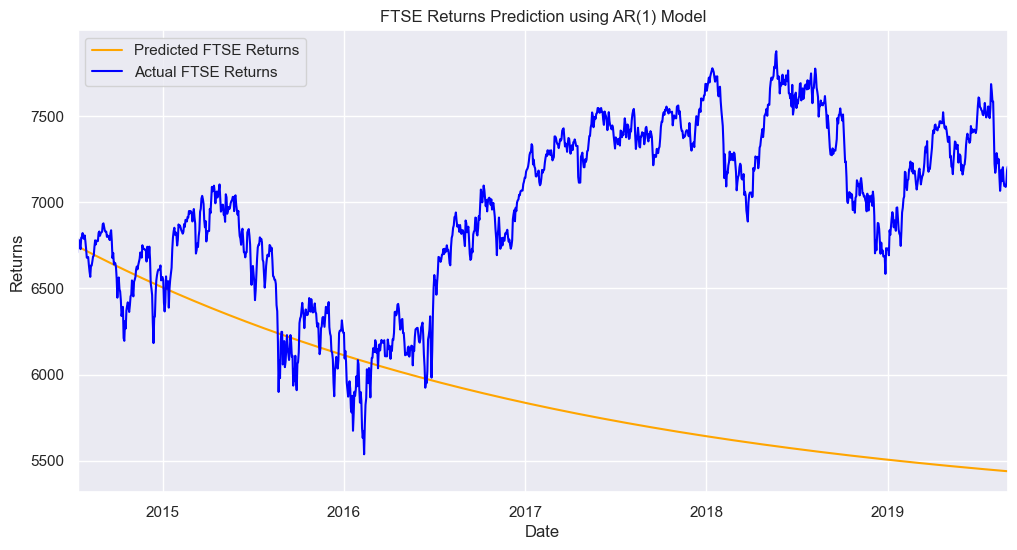

In [46]:
#plot the predictions
plt.figure(figsize=(12, 6))
df_pred[start_date:end_date].plot(label='Predicted FTSE Returns', color='orange')
df_test.ftse[start_date:end_date].plot(label='Actual FTSE Returns', color='blue')
plt.title('FTSE Returns Prediction using AR(1) Model')
plt.xlabel('Date')
plt.ylabel('Returns')
plt.legend()
plt.show()

* This suggests that AR model is not good for non stationary data predictions

### Using Returns